## Purpose 

This notebook will:
- check the aws bucket for the group 
- access the data in the buckets
- create a file system on the local machine
  - file structure is:
    - clinic/test or train // files 
- download the files from the aws into the folders created above 
  - this will create a folder structure of test/ train for each clinic
- this will enable a model to be run for each set 'clinic' with the correct test and train data set thereby simulating the federated learning environment 
- it also displays a random set of images taken from the file structure developed above in a grid format.

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import boto3
import os 

In [28]:

## list the buckets 
! aws s3 ls

2024-08-14 17:57:37 gastric-cancer-data
2024-08-16 17:35:42 gastric-data-zip


In [55]:
## Check on the data in the S3 bucket 
! aws s3 ls --recursive --summarize --human-readable s3://gastric-cancer-data/

## file structure is in the following format 
## clinic(0-3) / train_data||test_data / 0 or 1 / file_name.png 

2024-08-16 18:22:56    6.0 KiB .DS_Store
2024-08-16 18:22:56    6.0 KiB 0/.DS_Store
2024-08-16 18:22:56    6.0 KiB 0/test_data/.DS_Store
2024-08-16 18:22:56    2.1 KiB 0/test_data/0/LIDC-IDRI-0649_1/91921_000039_01-01-2000-CT LUNG SCREEN-00055_09630_doctor_anon_session_2.png
2024-08-16 18:22:56    2.1 KiB 0/test_data/0/LIDC-IDRI-0649_1/91921_000148_01-01-2000-CT LUNG SCREEN-00055_09630_doctor_anon_session_2.png
2024-08-16 18:22:56    2.1 KiB 0/test_data/0/LIDC-IDRI-0649_10/2246_000032_01-01-2000-CT LUNG SCREEN-00055_09630_doctor_anon_session_0.png
2024-08-16 18:22:56    2.2 KiB 0/test_data/0/LIDC-IDRI-0649_10/2246_000033_01-01-2000-CT LUNG SCREEN-00055_09630_doctor_anon_session_0.png
2024-08-16 18:22:56    1.9 KiB 0/test_data/0/LIDC-IDRI-0649_10/2246_000234_01-01-2000-CT LUNG SCREEN-00055_09630_doctor_anon_session_0.png
2024-08-16 18:22:56    1.9 KiB 0/test_data/0/LIDC-IDRI-0649_10/5407_000032_01-01-2000-CT LUNG SCREEN-00055_09630_doctor_anon_session_1.png
2024-08-16 18:22:56    2.0 Ki

In [44]:
# Load Data into train and test sets for each clinic 

## Get a list of all the file names in the bucket -- there are 22596 files in the bucket - these are the 'keys' for the bucket which act as filenames in a classic sense 

## AWS doesn't use a classic file structure

bucket = 'gastric-cancer-data'
s3 = boto3.resource("s3") 
s3_bucket = s3.Bucket(bucket)
filenames = []
for files in s3_bucket.objects.all():
    filenames.append(files.key)

In [200]:
## Download and pre-process images from s3 
## files in the list above already - intention is this is used in a loop ton create train and test images for each clinic (4 in total)
from PIL import Image 
import io
def download_process(key,file_name, bucket = 'gastric-cancer-data'):
    """ 
    This function will 
    """
    s3 = boto3.resource("s3")
    s3_bucket = s3.Bucket(bucket)
    image = s3_bucket.Object(key) 
    img_data = image.get().get('Body').read() ## read the file from aws 
    img = Image.open(io.BytesIO(img_data)) ## open the image 
    img_arr = np.array(img, dtype = np.float32) ## Create the array 
    img_arr = img_arr[:,:,:3] ## Reshape the array to [xx,xx,3] making it suitable for transfer learning purposes
    np.savez_compressed(file_name, img_arr)
    #return img_arr 

In [ ]:
# npzfile = np.load() usage for inspecting the data 
data = np.load('path to file .npz')        

for key in data.keys():
    print(key)                 
    print(data[key])               

In [221]:
## Check if the folders are created - if not create them for each clinic
## Save the data for each clinic in test and train folders 
import shutil 
# Path to folder where you want the data stored 
mas_folder = '/Users/james/projects/36105_ilab/project_files/ilab-07-2/data'
# sub folders in each clinic folder 
fols = ['train', 'test']
for clin in range(4):
    direct = os.path.join(mas_folder, 'clin_'+str(clin)) 
    if os.path.exists(direct) == False:
        os.mkdir(direct)
        for folder in fols:
            sub = os.path.join(direct, folder)
            os.mkdir(sub)
    else:
        shutil.rmtree(direct)

In [229]:
## Master folder structure 
### This saves the files for the different clinics into train and test folders to enable the creation of data loaders in the future while separating out the different clinics.
### It renames the files - removing any backslashes and spaces before saving the files in a .npz format for efficiency and space usage. 
### an example file name structures is '/clin_1/test/1-test_data-0-LIDC-IDRI-0641_1-10_000024_01-01-2000-CHEST-55759_31163-34230_doctor_anon_session_0.npz'

## This will enable the development of four models based on four different data sets to simulate the federated learning setting. 

#** This took more some time to execute - ~~ 60 mins on a macbook pro **# 
mas_folder ## taken from cell above 
for img_name in filenames:
    if img_name.endswith('.png'):
        img_file = img_name.replace('/','-')
        img_file = img_file.replace('png', 'npz')
        img_file = img_file.replace(' ', '-')
        print(img_file)
        for i in range(3,4):
            if img_name.startswith(str(i)):
                if img_name.startswith(str(i)+'/test_data'):
                    direct_test = os.path.join(mas_folder, 'clin_'+str(i)+'/test/',img_file)
                    download_process(img_name, direct_test)
                if img_name.startswith(str(i)+'/train_data'):
                    direct_train = os.path.join(mas_folder, 'clin_'+str(i)+'/train/',img_file)
                    download_process(img_name, direct_train)
    else:
        continue                

0-test_data-0-LIDC-IDRI-0649_1-91921_000039_01-01-2000-CT-LUNG-SCREEN-00055_09630_doctor_anon_session_2.npz
0-test_data-0-LIDC-IDRI-0649_1-91921_000148_01-01-2000-CT-LUNG-SCREEN-00055_09630_doctor_anon_session_2.npz
0-test_data-0-LIDC-IDRI-0649_10-2246_000032_01-01-2000-CT-LUNG-SCREEN-00055_09630_doctor_anon_session_0.npz
0-test_data-0-LIDC-IDRI-0649_10-2246_000033_01-01-2000-CT-LUNG-SCREEN-00055_09630_doctor_anon_session_0.npz
0-test_data-0-LIDC-IDRI-0649_10-2246_000234_01-01-2000-CT-LUNG-SCREEN-00055_09630_doctor_anon_session_0.npz
0-test_data-0-LIDC-IDRI-0649_10-5407_000032_01-01-2000-CT-LUNG-SCREEN-00055_09630_doctor_anon_session_1.npz
0-test_data-0-LIDC-IDRI-0649_10-5407_000033_01-01-2000-CT-LUNG-SCREEN-00055_09630_doctor_anon_session_1.npz
0-test_data-0-LIDC-IDRI-0649_10-5407_000234_01-01-2000-CT-LUNG-SCREEN-00055_09630_doctor_anon_session_1.npz
0-test_data-0-LIDC-IDRI-0649_10-91916_000032_01-01-2000-CT-LUNG-SCREEN-00055_09630_doctor_anon_session_2.npz
0-test_data-0-LIDC-IDRI-064

In [318]:
## Create a set of random set of files names to be displayed 

from pathlib import Path 
import random 
## Set path list to loca computer 
pathlist = Path('/Users/james/projects/36105_ilab/project_files/ilab-07-2/data').glob('**/*')

nof_samples = 15 

rc = []
c = []
ranls = []
for k, path in enumerate(pathlist): 
    if str(path).endswith('.npz'): 
        c.append(path)
        i = random.randint(0,k)
        ranls.append(i)
        if len(rc) < nof_samples:
            ## to move past 'k' values that do not end in .npz
            try:
                if str(c[i]) not in rc: ## make sure there are no double ups in the random list - make sure all images are different
                    rc.append(str(c[i])) ## turn path into string // would work with either in notebook
                else:
                    continue
            except:
                pass 
        #else:
        #    continue
    else:
        continue 
print(len(rc))
print(rc) 
print(len(c))

15
['/Users/james/projects/36105_ilab/project_files/ilab-07-2/data/clin_1/test/1-test_data-0-LIDC-IDRI-0892_1-204225_000042_01-01-2000-32452_5916-63106_doctor_anon_session_0.npz', '/Users/james/projects/36105_ilab/project_files/ilab-07-2/data/clin_1/test/1-test_data-0-LIDC-IDRI-1004_2-2_000294_01-01-2000-CHEST-11943_30946-Recon-2-LOW-DOSE-THROUGH-LUNGS-02384_doctor_anon_session_2.npz', '/Users/james/projects/36105_ilab/project_files/ilab-07-2/data/clin_1/test/1-test_data-0-LIDC-IDRI-0855_9-80770_000061_01-01-2000-13854_5476-ThoraxRoutine--3.0--B31f-57503_doctor_anon_session_0.npz', '/Users/james/projects/36105_ilab/project_files/ilab-07-2/data/clin_1/test/1-test_data-0-LIDC-IDRI-0807_2-4_000194_01-01-2000-23693_1775-NLST-TLC-VOL-B30F-11534_doctor_anon_session_3.npz', '/Users/james/projects/36105_ilab/project_files/ilab-07-2/data/clin_1/test/1-test_data-0-LIDC-IDRI-0916_3-7108_000064_01-01-2000-CT-LUNG-SCREEN-89609_13546_doctor_anon_session_1.npz', '/Users/james/projects/36105_ilab/proj

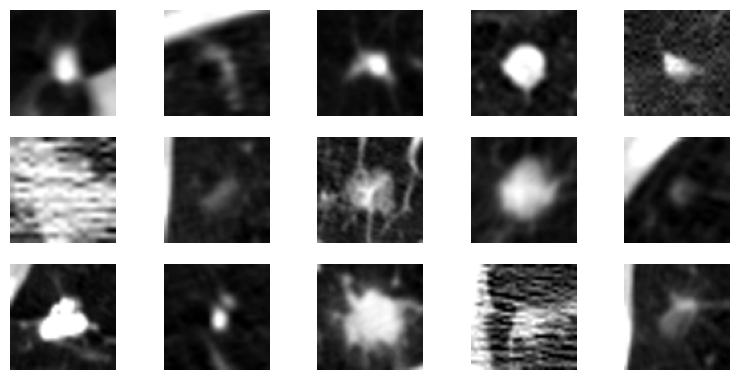

In [320]:
## Print random images from the Dataset 
count = len(rc)
plt.figure(figsize=(11, 18))

for k, path in enumerate(rc):
    img1 = np.load(path)
    for ix in img1.keys():                    
        arr = img1[key]
        i = Image.fromarray(arr.astype(np.uint8))
        resize = (80, 80)
        i = i.resize(resize)
        plt.subplots_adjust(bottom=0.3, right=0.8, top=0.5)
        ax = plt.subplot(3, 5, k + 1) ## make sure the grid size fits the number of images in the rc list. 
        ax.axis('off')
        plt.imshow(i)
